# HCR-Net 
An implementation of the paper: "Chauhan, V. K., Singh, S., & Sharma, A. (2022). 
HCR-Net: A deep learning based script independent handwritten character recognition network. arXiv preprint arXiv:2108.06663."

@author:
    Vinod Kumar Chauhan,
    Department of Engineering,
    University of Oxford, UK
    Email id: jmdvinodjmd@gmail.com / vinod.kumar@eng.ox.ac.uk

Created on: June 2021, Last modified on: August, 2022.

### HCR-Net (without augmentation)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0         
                                                                 
 block3_conv1 (Conv2D)       (None, 8, 8, 256)        

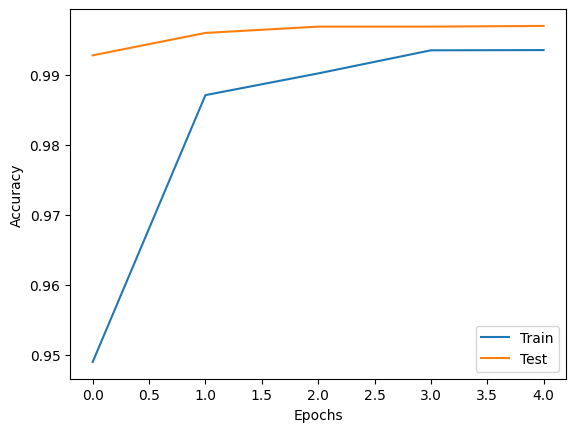

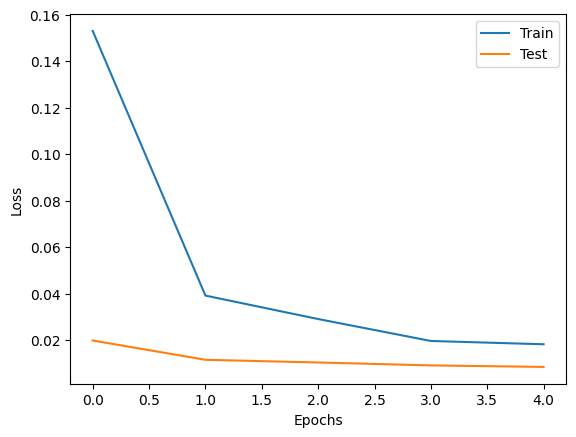

1/1 [==============================] - 9s 9s/step
Total time: 23 seconds


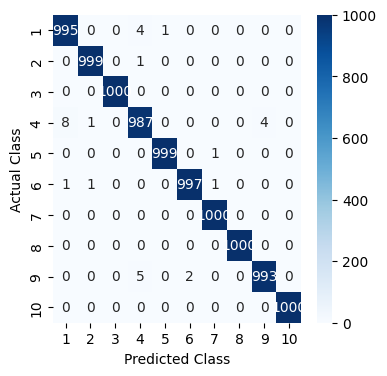

In [4]:
##############################################################################
import logging
logging.getLogger("tensorflow").disabled = True
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense, MaxPool2D
from tensorflow.keras.layers import BatchNormalization as BatchNorm

# pre-trained models
from keras.applications.vgg16 import VGG16

# custom learning rates
import learning_rate as lr

# import custom 
from TimeHist import TimeHistory

%matplotlib inline

##############################################################################
# please change following for your dataset (dataset details and learning params)
# dataset details
train_data_dir = './Data/Offline/UCI_DevanagariHandwrittenCharacterDataset/digits/Train'
validation_data_dir = './Data/Offline/UCI_DevanagariHandwrittenCharacterDataset/digits/Test'
afro_mnist_train_x_dir = './Data/Offline/AfroMNIST-master/Ethiopic/Ethiopic_MNIST_X_train.npy'
afro_mnist_test_x_dir = './Data/Offline/AfroMNIST-master/Ethiopic/Ethiopic_MNIST_X_test.npy'
afro_mnist_train_y_dir = './Data/Offline/AfroMNIST-master/Ethiopic/Ethiopic_MNIST_y_train.npy'
afro_mnist_test_y_dir = './Data/Offline/AfroMNIST-master/Ethiopic/Ethiopic_MNIST_y_test.npy'
class_labels = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"]


afro_y_train = to_categorical(np.load(afro_mnist_train_y_dir).flatten().T, 10)
afro_y_test  = to_categorical(np.load(afro_mnist_test_y_dir).flatten().T, 10)
afro_x_train = tf.pad(tensor=np.load(afro_mnist_train_x_dir), paddings=[[0, 0], [2,2], [2,2]])
afro_x_test = tf.pad(tensor=np.load(afro_mnist_test_x_dir), paddings=[[0, 0], [2,2], [2,2]])
afro_x_train = tf.image.grayscale_to_rgb(tf.expand_dims(afro_x_train, axis=3))
afro_x_test =  tf.image.grayscale_to_rgb(tf.expand_dims(afro_x_test, axis=3))

nb_train_samples = 60000
nb_validation_samples = 10000
num_classes = len(class_labels)

# learning params
epochs1 = 3
epochs2 = 2
learning_rate1 = lr.decayed_learning_rate
learning_rate2 = lr.decayed_learning_rate_tuned20

# set seeds for reproduceability
np.random.seed(1)
tf.random.set_seed(1)
##############################################################################
batch_size = 32
# dimensions of our images.
img_width, img_height = 32, 32
input_shape = (img_width, img_height, 3)
##############################################################################
#### TRAINING PHASE - I #########
#################################
# using VGG16: load model without classifier layer, and using weights from ImageNet
source_model = VGG16(include_top=False, input_shape=input_shape)

# create a new model using lower layers of VGG16 upto block4_conv2,
# and mark as not trainable, i.e., freeze the lower layers
model = Sequential()
for layer in source_model.layers[:-6]:
    layer.trainable = False
    model.add(layer)

# add extra layers at top of lower layers of pre-trained VGG16
model.add(BatchNorm())
model.add(MaxPool2D())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
#model.add(Dense(512, activation='leaky_relu'))
model.add(BatchNorm())
model.add(Dropout(0.35))
model.add(Dense(512, activation='relu'))
#model.add(Dense(512, activation='leaky_relu'))
model.add(BatchNorm())
model.add(Dropout(0.35))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# using ImageDataGenerator to load and scale data
train_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(
                    x=afro_x_train,
                    y=afro_y_train,
                    batch_size=batch_size,
                    shuffle=True,
                    seed=13)

validation_generator = test_datagen.flow(
                    x=afro_x_test,
                    y=afro_y_test,
                    batch_size=nb_validation_samples,
                    shuffle=False)

# define callback for custom learning rate
callback = tf.keras.callbacks.LearningRateScheduler(learning_rate1)

# define a callback for the epoch times
time_hist1 = TimeHistory()
'''
history1 = model.fit(
                train_generator,
                steps_per_epoch=nb_train_samples // batch_size,
                epochs=epochs1,
                callbacks=[callback, time_hist1],
                validation_data=validation_generator,
                validation_steps=1)
'''
history1 = model.fit(
                train_generator,
                steps_per_epoch=nb_train_samples // batch_size,
                epochs=epochs1,
                callbacks=[callback, time_hist1],
                validation_data=validation_generator,
                validation_steps=1)


# save the model
model.save_weights('./results/HCR-Net-I.weights.h5')

#################################
#### TRAINING PHASE - II #########
#################################
# fine tuning the model by unfreezing the lower layers (used from VGG16)
for layer in model.layers[:12]:
    layer.trainable = True

# reset the image generators
train_generator.reset()
validation_generator.reset()

# recompile the model
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# define callback for custom learning rate
callback = tf.keras.callbacks.LearningRateScheduler(learning_rate2)

# define a custom callback for the epoch times
time_hist2 = TimeHistory()
history2 = model.fit(
                train_generator,
                steps_per_epoch=nb_train_samples // batch_size,
                epochs=epochs2,
                callbacks=[callback, time_hist2],
                validation_data=validation_generator,
                validation_steps=1)


# save the model
model.save_weights('./results/HCR-Net-II.weights.h5')

##############################################################################
# plot the convergence, in terms of accuracy and loss
plt.plot(history1.history['accuracy']+history2.history['accuracy'])
plt.plot(history1.history['val_accuracy']+history2.history['val_accuracy'])
# plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

plt.plot(history1.history['loss']+history2.history['loss'])
plt.plot(history1.history['val_loss']+history2.history['val_loss'])
# plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# evaluate model and plot confusion matrix
# filenames = validation_generator.filenames
predict = model.predict(validation_generator)
y_pred = np.argmax(predict,axis=-1)

x_gen,y_gen = validation_generator.next()
y_gen = np.argmax(y_gen, axis=-1)
cf_matrix = confusion_matrix(y_gen ,y_pred)

# calculate size of confusion matrix figure, and plot it
fig, ax = plt.subplots(figsize=(math.ceil(num_classes/3.0), math.ceil(num_classes/3.0)))
labels = list(class_labels)
sns.heatmap(cf_matrix, annot=True, xticklabels=labels, yticklabels=labels, fmt='', cmap='Blues')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')




total_time = sum(time_hist1.times) + sum(time_hist2.times)
print("Total time: %d seconds" % (total_time/ 60))
##############################################################################

In [5]:
# calculate different metrics for HCR-Net on the test dataset
print('precision_score: ', precision_score(y_gen ,y_pred, average="macro"))
print('recall_score   : ', recall_score(y_gen, y_pred, average="macro"))
print('f1_score       : ', f1_score(y_gen, y_pred, average="macro"))
print('accuracy_score : ', accuracy_score(y_gen ,y_pred, normalize=True))

print("\nBest accuracy  : ", max(max(history1.history['val_accuracy']), max(history2.history['val_accuracy'])))

precision_score:  0.9969997718210533
recall_score   :  0.9970000000000001
f1_score       :  0.9969988931749301
accuracy_score :  0.997

Best accuracy  :  0.996999979019165


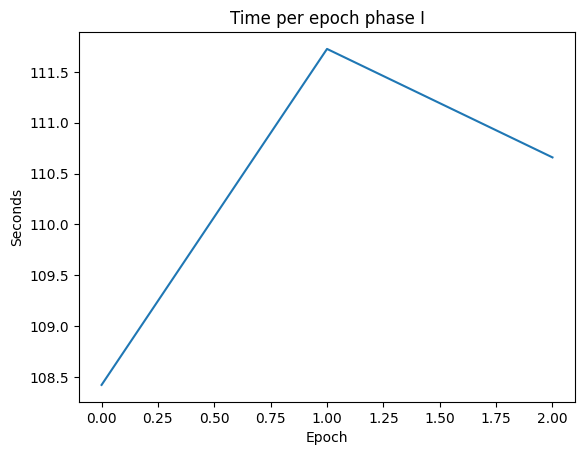

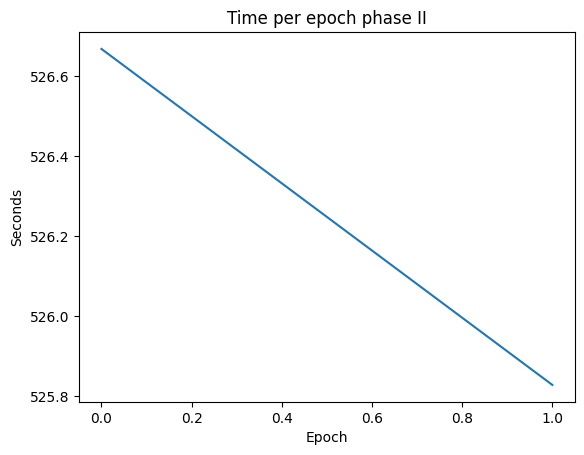

Text(0.5, 14.722222222222216, 'Predicted Class')

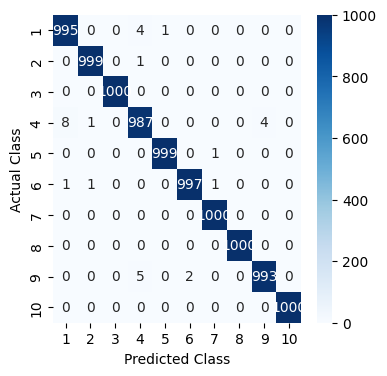

In [7]:
plt.plot(time_hist1.times)
plt.ylabel('Seconds')
plt.xlabel('Epoch')
plt.title("Time per epoch phase I")
plt.show()

# plot time each epoch took in phase 2
plt.plot(time_hist2.times)
plt.ylabel('Seconds')
plt.xlabel('Epoch')
plt.title("Time per epoch phase II")
plt.show()


# calculate size of confusion matrix figure, and plot it
fig, ax = plt.subplots(figsize=(math.ceil(num_classes/3.0), math.ceil(num_classes/3.0)))
sns.heatmap(cf_matrix, annot=True, xticklabels=class_labels, yticklabels=class_labels, fmt='', cmap='Blues')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')

In [5]:
total_time = sum(time_hist1.times) + sum(time_hist2.times)
print(total_time)

14756.758820295334
